Проект для «Викишоп» c BERT.

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**В данной работе нам требуется:**

1. Загрузите и подготовьте данные.
2. Обучите разные модели.
3. Сделайте выводы.

In [1]:
# !pip install optuna
# !pip install optuna-integration
# !pip install missingno

# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install transformers
# !pip install tqdm
# !pip install --upgrade transformers datasets
# !pip install sentencepiece
# !pip install -U spacy
# !pip install -U pip setuptools wheel
# !python -m spacy download en_core_web_sm

# !pip uninstall transformers -y
# !pip install transformers[torch]




In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st

from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import make_scorer, mean_squared_error, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import optuna
from optuna.integration import OptunaSearchCV
from optuna.visualization import plot_contour
from catboost import CatBoostRegressor, CatBoostClassifier
import missingno as msno

import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import transformers
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, DataCollatorWithPadding, DistilBertTokenizer, DistilBertModel, AutoModel, AutoTokenizer, AdamW, Trainer, TrainingArguments

from tqdm import tqdm
from tqdm import notebook 
from datasets import Dataset

import spacy
torch.cuda.is_available()

True

### Шаг 1. Загрузка данных

In [3]:
try:
    toxic_comments = pd.read_csv('datasets/toxic_comments.csv')
except:   
    toxic_comments = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [4]:
toxic_comments = toxic_comments.sample(10000).reset_index(drop=True)
toxic_comments.head(20)

,Unnamed: 0,text,toxic
0,124732,And it turns out that webpage has a species ID...,0
1,13246,"""\n\nExcellent explanation, PhD Historian, tha...",0
2,133041,"""\n\n Olympic Sportsfans \n\nTotallympics\n\nH...",0
3,96492,"""\nYes, well, that's what's been happening. It...",0
4,105619,"Central America Group \n\nBlank Verse,\nI hope...",0
5,69839,"""\n\n Restaurants \n\nThank you, truly, for pa...",0
6,25530,"Chrisnoscrub047, please add your contribution ...",0
7,102006,""":SilkTork, I struck some comments on Fainites...",0
8,112573,"This line has now been removed, I saw no probl...",0
9,123412,"""\nA.F. – In case you missed out on the random...",0


In [5]:
toxic_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  10000 non-null  int64 
 1   text        10000 non-null  object
 2   toxic       10000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 234.5+ KB


**Вывод: Данные соответсвуют описанию и готовы к предобработке.**

### Шаг 2. Изучение данных

Проверка на дубликаты:

In [6]:
toxic_comments.duplicated().sum()

0

Проверка на пропуски:

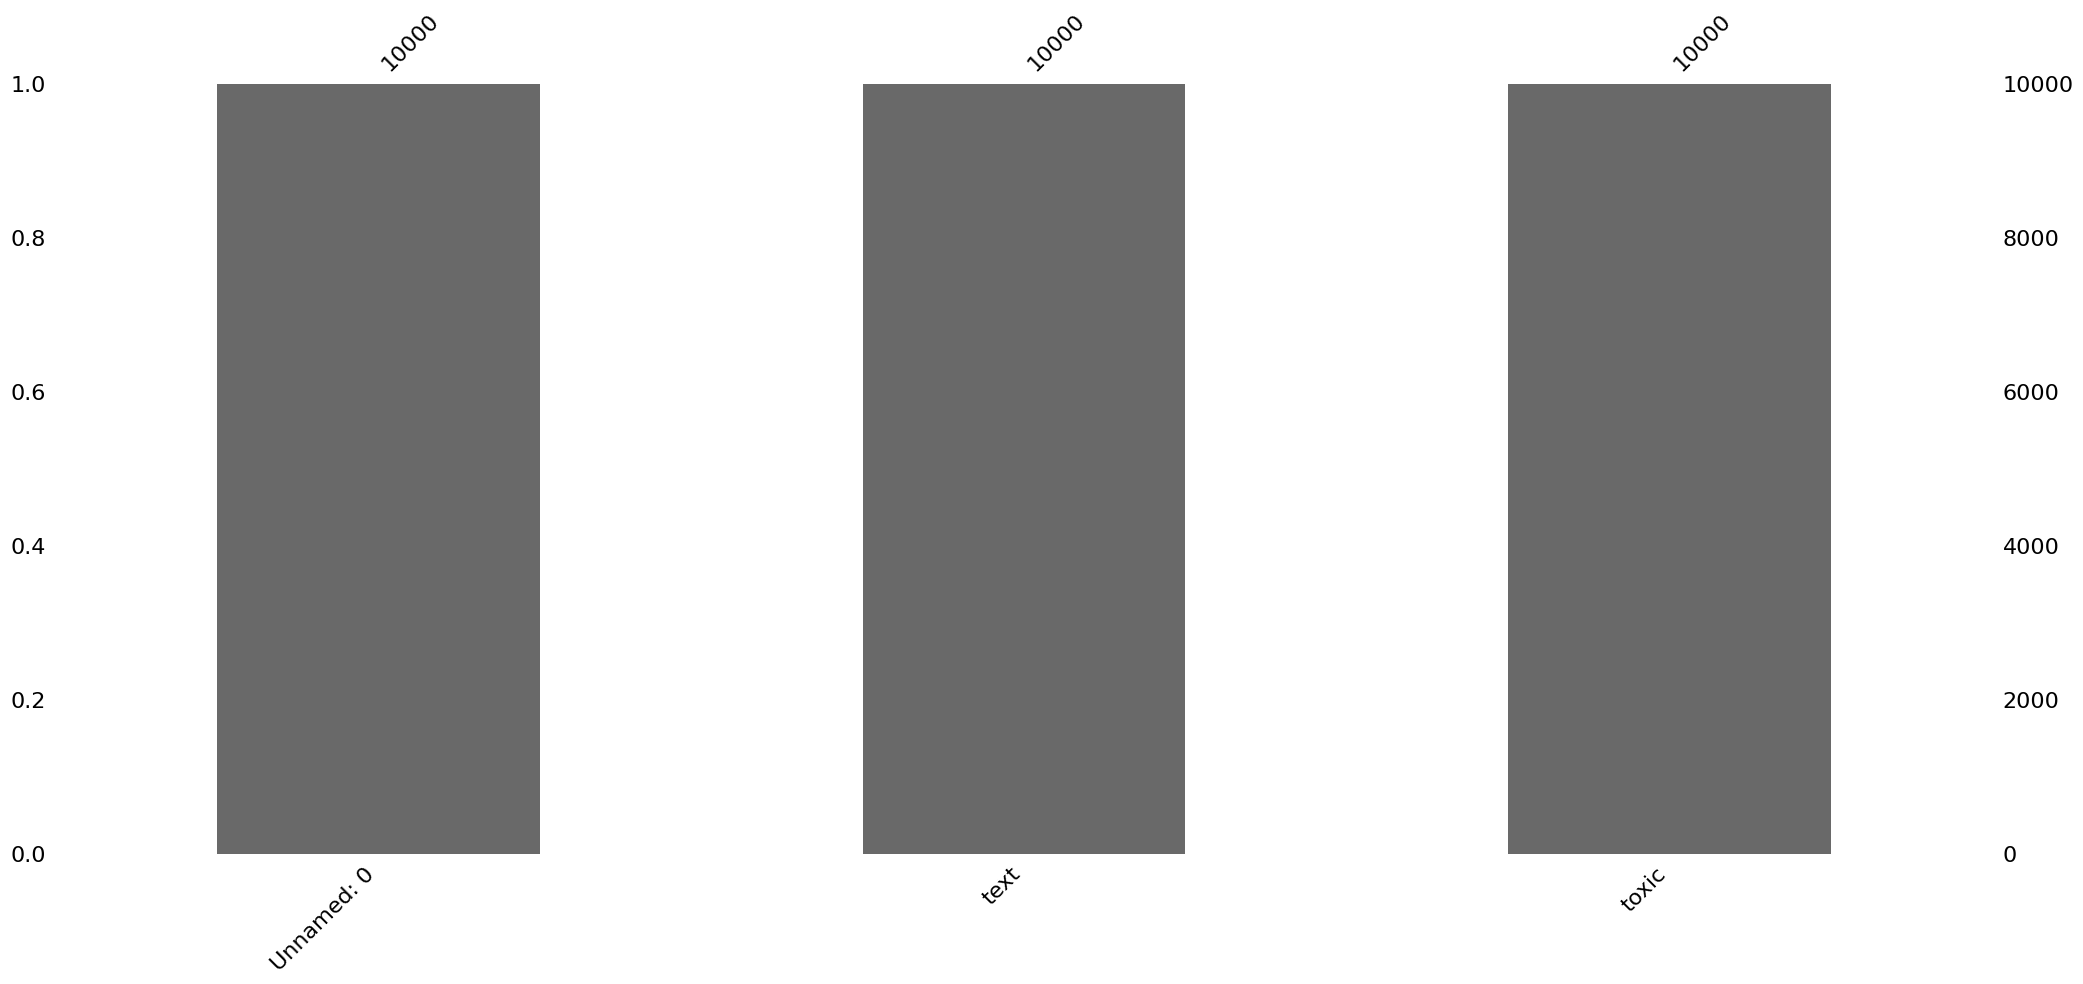

In [7]:
msno.bar(toxic_comments);

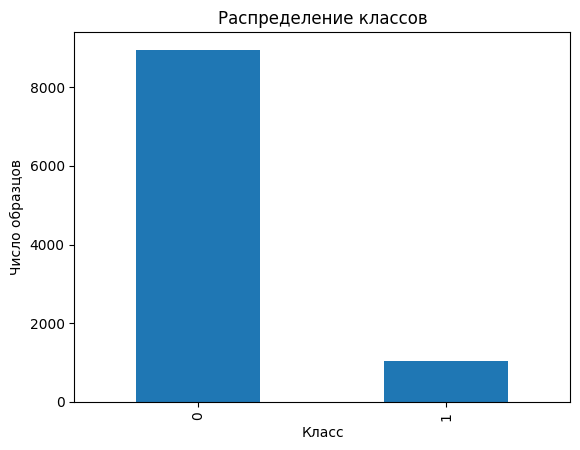

In [8]:
class_counts = toxic_comments['toxic'].value_counts()

class_counts.plot(kind='bar')
plt.title('Распределение классов')
plt.xlabel('Класс')
plt.ylabel('Число образцов')
plt.show()

In [9]:
# Оптимизация числовых типов данных
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию
        # Размер занимаемой памяти до оптимизации (в Мб)
        before_size = df.memory_usage().sum() / 1024**2    
        for column in df.columns:
            column_type = df[column].dtypes
            if column_type in numerics:
                column_min = df[column].min()
                column_max = df[column].max()
                if str(column_type).startswith('int'):
                    if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                        df[column] = df[column].astype(np.int8)
                    elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                        df[column] = df[column].astype(np.int16)
                    elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                        df[column] = df[column].astype(np.int32)
                    elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                        df[column] = df[column].astype(np.int64)  
                else:
                    if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                        df[column] = df[column].astype(np.float32)
                    else:
                        df[column] = df[column].astype(np.float64)    
        # Размер занимаемой памяти после оптимизации (в Мб)
        after_size = df.memory_usage().sum() / 1024**2
        if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                             .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
        return df
optimize_memory_usage(toxic_comments, print_size=True)

Размер использования памяти: до  0.23 Mb - после  0.12 Mb (45.8%)


,Unnamed: 0,text,toxic
0,124732,And it turns out that webpage has a species ID...,0
1,13246,"""\n\nExcellent explanation, PhD Historian, tha...",0
2,133041,"""\n\n Olympic Sportsfans \n\nTotallympics\n\nH...",0
3,96492,"""\nYes, well, that's what's been happening. It...",0
4,105619,"Central America Group \n\nBlank Verse,\nI hope...",0
...,...,...,...
9995,143394,"""\nYou just admitted it is a synthesis. That v...",0
9996,119273,Delete this farcical article \nNew anti-Semiti...,0
9997,119616,Template:uw-delete1 >,0
9998,109637,"Well, justice is never being given. You have t...",0


**Вывод: В данных отсутствуют пропуски и дубликаты.**

### Шаг 3. Обучение моделей.

In [10]:
nlp = spacy.load('en_core_web_sm')

def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

tqdm.pandas()
toxic_comments['lemmatized_text'] = toxic_comments['text'].progress_apply(lemmatize_text)
toxic_comments['lemmatized_text'].head(20)

100%|██████████| 10000/10000 [01:52<00:00, 88.82it/s]


0     and it turn out that webpage have a species ID...
1     " \n\n Excellent explanation , PhD Historian ,...
2     " \n\n  Olympic Sportsfans \n\n Totallympics \...
3     " \n yes , well , that be what be be happen . ...
4     Central America Group \n\n Blank Verse , \n I ...
5     " \n\n  restaurant \n\n thank you , truly , fo...
6     chrisnoscrub047 , please add your contribution...
7     " : SilkTork , I strike some comment on Fainit...
8     this line have now be remove , I see no proble...
9     " \n A.F. – in case you miss out on the random...
10                                  be make 2 month ago
11                            . \n yes , fine . do that
12                  hi John . fine with I ! good regard
13    " : : : : : the malinger " " issue " " be a to...
14    taiwanese people \n\n Hi , there be a dispute ...
15    " \n\n  Bektashi \n may I learn what be " " ra...
16    Unprotection \n from what I remember , protect...
17    Umm ... I be no geologist , but ?   I be s

Модель BERT:

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using device: {device}')

Using device: cuda


In [12]:
# model_path = './bert-base-uncased'
# tokenizer_path = './bert-base-uncased'

# if os.path.exists(model_path) and os.path.exists(tokenizer_path):
#     model = BertModel.from_pretrained(model_path)
#     tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
# else:
#     tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#     model = BertModel.from_pretrained('bert-base-uncased')
#     model.save_pretrained(model_path)
#     tokenizer.save_pretrained(tokenizer_path)

# model_path = './distilbert-base-uncased'
# tokenizer_path = './distilbert-base-uncased'

# if os.path.exists(model_path) and os.path.exists(tokenizer_path):
#     model = DistilBertModel.from_pretrained(model_path)
#     tokenizer = DistilBertTokenizer.from_pretrained(tokenizer_path)
# else:
#     tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
#     model = DistilBertModel.from_pretrained('distilbert-base-uncased')
#     model.save_pretrained(model_path)
#     tokenizer.save_pretrained(tokenizer_path)

# model_path = './albert-base-v2'
# tokenizer_path = './albert-base-v2'

# if os.path.exists(model_path) and os.path.exists(tokenizer_path):
#     # Загрузка модели и токенизатора из локального хранилища
#     model = AlbertModel.from_pretrained(model_path)
#     tokenizer = AlbertTokenizer.from_pretrained(tokenizer_path)
# else:
#     # Загрузка модели и токенизатора из интернета и сохранение локально
#     model = AlbertModel.from_pretrained('albert-base-v2')
#     tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
#     model.save_pretrained(model_path)
#     tokenizer.save_pretrained(tokenizer_path)

# model_name = 'unitary/toxic-bert'

# model_path = './toxic-bert'
# tokenizer_path = './toxic-bert'

# if os.path.exists(model_path) and os.path.exists(tokenizer_path):
#     model = AutoModel.from_pretrained(model_path)
#     tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
# else:
#     tokenizer = AutoTokenizer.from_pretrained(model_name)
#     model = AutoModel.from_pretrained(model_name)
#     model.save_pretrained(model_path)
#     tokenizer.save_pretrained(tokenizer_path)

In [13]:
dataset = Dataset.from_pandas(toxic_comments[['lemmatized_text', 'toxic']])
dataset = dataset.rename_column('lemmatized_text', 'text')
dataset = dataset.rename_column('toxic', 'labels')

In [14]:
train_test_ratio = 0.8
train_dataset, test_dataset = dataset.train_test_split(test_size=1-train_test_ratio).values()

In [15]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [16]:
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=7,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    eval_strategy="epoch",
    save_strategy="epoch", 
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)


def compute_metrics(p):
    predictions, labels = p
    preds = predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    return {"f1": f1}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)


In [18]:
trainer.train()

  0%|          | 0/3500 [00:00<?, ?it/s]

c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


{'loss': 0.2011, 'grad_norm': 7.039880752563477, 'learning_rate': 5e-05, 'epoch': 1.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 0.14666423201560974, 'eval_f1': 0.9552821746375296, 'eval_runtime': 21.2915, 'eval_samples_per_second': 93.934, 'eval_steps_per_second': 5.871, 'epoch': 1.0}
{'loss': 0.1192, 'grad_norm': 0.1731484830379486, 'learning_rate': 4.166666666666667e-05, 'epoch': 2.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 0.17282739281654358, 'eval_f1': 0.9574288857457175, 'eval_runtime': 22.9268, 'eval_samples_per_second': 87.234, 'eval_steps_per_second': 5.452, 'epoch': 2.0}
{'loss': 0.063, 'grad_norm': 17.184101104736328, 'learning_rate': 3.3333333333333335e-05, 'epoch': 3.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 0.17874513566493988, 'eval_f1': 0.9549927314304638, 'eval_runtime': 28.281, 'eval_samples_per_second': 70.719, 'eval_steps_per_second': 4.42, 'epoch': 3.0}
{'loss': 0.0278, 'grad_norm': 2.6566953659057617, 'learning_rate': 2.5e-05, 'epoch': 4.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 0.18558233976364136, 'eval_f1': 0.9625397309838425, 'eval_runtime': 22.6201, 'eval_samples_per_second': 88.417, 'eval_steps_per_second': 5.526, 'epoch': 4.0}
{'loss': 0.0052, 'grad_norm': 0.010518546216189861, 'learning_rate': 1.6666666666666667e-05, 'epoch': 5.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 0.2740466892719269, 'eval_f1': 0.9598778445084328, 'eval_runtime': 17.2702, 'eval_samples_per_second': 115.806, 'eval_steps_per_second': 7.238, 'epoch': 5.0}
{'loss': 0.0034, 'grad_norm': 0.002097586402669549, 'learning_rate': 8.333333333333334e-06, 'epoch': 6.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 0.27005138993263245, 'eval_f1': 0.9626784575745666, 'eval_runtime': 23.0368, 'eval_samples_per_second': 86.817, 'eval_steps_per_second': 5.426, 'epoch': 6.0}
{'loss': 0.0001, 'grad_norm': 0.003779421094805002, 'learning_rate': 0.0, 'epoch': 7.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 0.27538275718688965, 'eval_f1': 0.96500589200678, 'eval_runtime': 22.8059, 'eval_samples_per_second': 87.697, 'eval_steps_per_second': 5.481, 'epoch': 7.0}
{'train_runtime': 3039.5952, 'train_samples_per_second': 18.424, 'train_steps_per_second': 1.151, 'train_loss': 0.05997336549844061, 'epoch': 7.0}


TrainOutput(global_step=3500, training_loss=0.05997336549844061, metrics={'train_runtime': 3039.5952, 'train_samples_per_second': 18.424, 'train_steps_per_second': 1.151, 'total_flos': 3683554775040000.0, 'train_loss': 0.05997336549844061, 'epoch': 7.0})

In [19]:
eval_results = trainer.evaluate()
print(f"F1 Score: {eval_results['eval_f1']}")

  0%|          | 0/125 [00:00<?, ?it/s]

F1 Score: 0.96500589200678


Тестирование лучшей модели:

### Шаг 4. Общий вывод

**Вывод**

1. **Задача данного проекта была в определении токсичных комментариев**

2. **В ходе предобработки данных не потребовалось ничего изменять, данные были в порядкеТак же была применена функция оптимизации числовых данных. В ходе всех обработок, объем датасета стал 1.97 мб(изначально было 3.65 мб)**

3. **Модель BertForSequenceClassification показала значение метрики f1 = 78.**
